In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt
from utils import plot_tsne
import numpy as np
import random
import argparse
from AutoEncoderDecoder import EncoderMnist, DecoderMnist, ClassifierMNIST, trainEncoderMNIST, trainClassifierMNIST, evaluateClassifierMNIST 
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
def freeze_seeds(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [3]:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

In [4]:
freeze_seeds(0)

In [5]:
import os
current_dir = os.getcwd()
train_dataset = datasets.MNIST(root=current_dir, train=True, download=False, transform=transform)
test_dataset  = datasets.MNIST(root=current_dir, train=False, download=False, transform=transform)

In [6]:
def print_images(batch_images, num_to_print):
    fig, axes = plt.subplots(1, num_to_print, figsize=(12, 4))

    for i in range(num_to_print):
        image = batch_images[i].detach().numpy().transpose(1, 2, 0)

        # Plot the image
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')

    plt.show()

Train Encoder
Epoch [1/5], Train Loss: 0.0064, Validation Loss: 0.0045
Epoch [2/5], Train Loss: 0.0038, Validation Loss: 0.0034
Epoch [3/5], Train Loss: 0.0032, Validation Loss: 0.0030
Epoch [4/5], Train Loss: 0.0029, Validation Loss: 0.0028
Epoch [5/5], Train Loss: 0.0027, Validation Loss: 0.0026


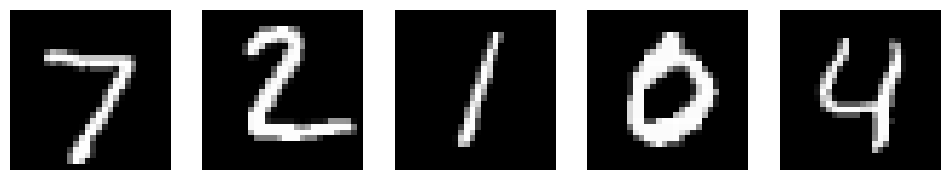

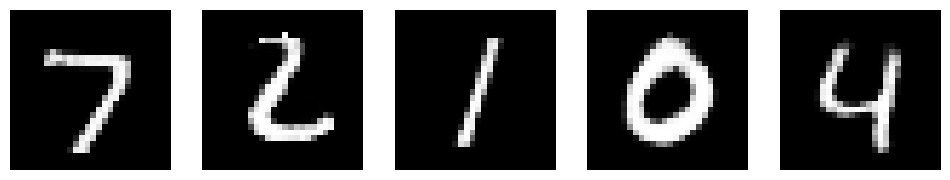

In [7]:
train_size = int(0.8 * len(train_dataset))
val_size   = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

dl_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
dl_test  = DataLoader(test_dataset, batch_size=32, shuffle=False)
dl_val   = DataLoader(val_dataset, batch_size=32, shuffle=False)

im_size = train_dataset[0][0].shape

encoder = EncoderMnist(in_channels=im_size[0] ,latent_dim=128)
decoder = DecoderMnist(latent_dim=128, out_channels=im_size[0])

epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainEncoderMNIST(encoder, decoder, epochs, dl_train, dl_val, device=device)

batch_images, _ = next(iter(dl_test))
batch_images    = batch_images.to(device)

print_images(batch_images, num_to_print=5)
encoded = encoder(batch_images)
decoded = decoder(encoded)
print_images(decoded, num_to_print=5)

# t-SNE
plot_tsne(encoder, dl_test ,device, "mnist_encoder_1_2_1")

In [8]:
# Adding a classifier
print("Section 1.2.1.2")
encoder.eval() # Set encoder to evaluation mode to avoid updates during training

# Freeze the encoder parameters
for param in encoder.parameters():
    param.requires_grad = False

classifier = ClassifierMNIST(latent_dim=128)
epochs = 5
trainClassifierMNIST(encoder, classifier, epochs, dl_train, dl_val, device)
evaluateClassifierMNIST(encoder, classifier, dl_test, device)

Section 1.2.1.2
Train Classifier
Epoch [1/5], Train Loss: 0.4788, Train Accuracy: 85.45%, Validation Loss: 0.4201, Validation Accuracy: 86.81%
Epoch [2/5], Train Loss: 0.3986, Train Accuracy: 87.79%, Validation Loss: 0.3863, Validation Accuracy: 87.98%
Epoch [3/5], Train Loss: 0.3776, Train Accuracy: 88.47%, Validation Loss: 0.3685, Validation Accuracy: 88.46%
Epoch [4/5], Train Loss: 0.3638, Train Accuracy: 88.98%, Validation Loss: 0.3622, Validation Accuracy: 88.66%
Epoch [5/5], Train Loss: 0.3518, Train Accuracy: 89.19%, Validation Loss: 0.3402, Validation Accuracy: 89.33%
Evaluate Classifier
Test Loss: 0.3230, Test Accuracy: 90.19%


In [9]:
print("Section 1.2.2")
from AutoEncoderDecoder import ClassifierMNIST122, trainClassifierMNIST122, evaluateClassifierMNIST122

encoder_122    = EncoderMnist(in_channels=im_size[0] ,latent_dim=128)
classifier_122 = ClassifierMNIST(latent_dim=128)

model = ClassifierMNIST122(encoder_122, classifier_122).to(device)

# Train the entire model (encoder + classifier) to minimize classification loss
epochs = 5
trainClassifierMNIST122(model, epochs, dl_train=dl_train, dl_val=dl_val, device=device)
evaluateClassifierMNIST122(model, dl_test, device)

# t-SNE
plot_tsne(encoder_122, dl_test ,device, "mnist_encoder_1_2_2")

Section 1.2.2
Train Encoder + Classifier
Epoch [1/5], Train Loss: 0.3603, Train Accuracy: 88.88%, Validation Loss: 0.1872, Validation Accuracy: 94.44%
Epoch [2/5], Train Loss: 0.1815, Train Accuracy: 94.75%, Validation Loss: 0.1319, Validation Accuracy: 96.08%
Epoch [3/5], Train Loss: 0.1376, Train Accuracy: 95.99%, Validation Loss: 0.1536, Validation Accuracy: 95.53%
Epoch [4/5], Train Loss: 0.1143, Train Accuracy: 96.59%, Validation Loss: 0.1217, Validation Accuracy: 96.67%
Epoch [5/5], Train Loss: 0.0973, Train Accuracy: 97.15%, Validation Loss: 0.1401, Validation Accuracy: 96.03%
Test Loss: 0.1341, Test Accuracy: 96.23%


In [ ]:
from AutoEncoderDecoder import ProjectionHead, trainEncoderMNIST123
print("Section 1.2.3")
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.MNIST(root=current_dir, train=True, download=False, transform=transform)
test_dataset  = datasets.MNIST(root=current_dir, train=False, download=False, transform=transform)

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

dl_train = DataLoader(train_dataset, batch_size=16, shuffle=True)
dl_test  = DataLoader(test_dataset, batch_size=16, shuffle=False)
dl_val   = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Initialize encoder, projection head, and loss function
encoder = EncoderMnist(in_channels=im_size[0] ,latent_dim=128)
projection_head = ProjectionHead(in_dim=128, out_dim=128).to(device)
encoder123 = torch.nn.Sequential(encoder, projection_head)

epochs = 5
trainEncoderMNIST123(encoder123, epochs, dl_train, device)

# Add a classifier
classifier123 = ClassifierMNIST(latent_dim=128)
trainClassifierMNIST(encoder123, classifier123, epochs, dl_train, dl_val, device)
evaluateClassifierMNIST(encoder123, classifier123, dl_test, device)

# t-SNE
plot_tsne(encoder, dl_test ,device, "mnist_encoder_1_2_3")

Section 1.2.3
trainEncoder123
Epoch 1/5, Loss: inf
Epoch 2/5, Loss: inf
